## Artigo Original: https://arxiv.org/abs/2306.17624

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/MyDrive

/content/drive/MyDrive


In [3]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

import torch.utils.data
import math


class LayerNorm(nn.Module):
    """
    layer normalization
    Simple layer norm object optionally used with the convolutional encoder.
    """

    def __init__(self, feature_dim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones((feature_dim,)))
        self.register_parameter("gamma", self.gamma)
        self.beta = nn.Parameter(torch.zeros((feature_dim,)))
        self.register_parameter("beta", self.beta)
        self.eps = eps

    def forward(self, x):
        # x: [batch_size, embed_dim]
        # normalize for each embedding
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # output shape is the same as x
        # Type not match for self.gamma and self.beta??????????????????????
        # output: [batch_size, embed_dim]
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


def get_activation_function(activation, context_str):
    if activation == "leakyrelu":
        return nn.LeakyReLU(negative_slope=0.2)
    elif activation == "relu":
        return nn.ReLU()
    elif activation == "sigmoid":
        return nn.Sigmoid()
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'gelu':
        return nn.GELU()
    else:
        raise Exception("{} activation not recognized.".format(context_str))


class SingleFeedForwardNN(nn.Module):
    """
        Creates a single layer fully connected feed forward neural network.
        this will use non-linearity, layer normalization, dropout
        this is for the hidden layer, not the last layer of the feed forard NN
    """

    def __init__(self, input_dim,
                 output_dim,
                 dropout_rate=None,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=''):
        '''

        Args:
            input_dim (int32): the input embedding dim
            output_dim (int32): dimension of the output of the network.
            dropout_rate (scalar tensor or float): Dropout keep prob.
            activation (string): tanh or relu or leakyrelu or sigmoid
            use_layernormalize (bool): do layer normalization or not
            skip_connection (bool): do skip connection or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(SingleFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        if dropout_rate is not None:
            self.dropout = nn.Dropout(p=dropout_rate)
        else:
            self.dropout = None

        self.act = get_activation_function(activation, context_str)

        if use_layernormalize:
            # the layer normalization is only used in the hidden layer, not the last layer
            self.layernorm = nn.LayerNorm(self.output_dim)
        else:
            self.layernorm = None

        # the skip connection is only possible, if the input and out dimention is the same
        if self.input_dim == self.output_dim:
            self.skip_connection = skip_connection
        else:
            self.skip_connection = False

        self.linear = nn.Linear(self.input_dim, self.output_dim)
        nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size,..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        # Linear layer
        output = self.linear(input_tensor)
        # non-linearity
        output = self.act(output)
        # dropout
        if self.dropout is not None:
            output = self.dropout(output)

        # skip connection
        if self.skip_connection:
            output = output + input_tensor

        # layer normalization
        if self.layernorm is not None:
            output = self.layernorm(output)

        return output


class MultiLayerFeedForwardNN(nn.Module):
    """
        Creates a fully connected feed forward neural network.
        N fully connected feed forward NN, each hidden layer will use non-linearity, layer normalization, dropout
        The last layer do not have any of these
    """

    def __init__(self, input_dim,
                 output_dim,
                 num_hidden_layers=0,
                 dropout_rate=None,
                 hidden_dim=-1,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=None):
        '''

        Args:
            input_dim (int32): the input embedding dim
            num_hidden_layers (int32): number of hidden layers in the network, set to 0 for a linear network.
            output_dim (int32): dimension of the output of the network.
            dropout (scalar tensor or float): Dropout keep prob.
            hidden_dim (int32): size of the hidden layers
            activation (string): tanh or relu
            use_layernormalize (bool): do layer normalization or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(MultiLayerFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers
        self.dropout_rate = dropout_rate
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.use_layernormalize = use_layernormalize
        self.skip_connection = skip_connection
        self.context_str = context_str

        self.layers = nn.ModuleList()
        if self.num_hidden_layers <= 0:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))
        else:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.hidden_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=self.use_layernormalize,
                                                   skip_connection=self.skip_connection,
                                                   context_str=self.context_str))

            for i in range(self.num_hidden_layers - 1):
                self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                       output_dim=self.hidden_dim,
                                                       dropout_rate=self.dropout_rate,
                                                       activation=self.activation,
                                                       use_layernormalize=self.use_layernormalize,
                                                       skip_connection=self.skip_connection,
                                                       context_str=self.context_str))

            self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size, ..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        output = input_tensor
        for i in range(len(self.layers)):
            output = self.layers[i](output)

        return output

In [4]:
import torch
import torch.nn as nn
import numpy as np

class SpherePositionEncoder(nn.Module):
    """
    Converte Lat/Lon -> Vetor 3D Unitário -> Frequências Senoidais (Multiescala)
    Baseado no conceito do Sphere2Vec.
    """
    def __init__(self, min_scale=1, max_scale=1000, num_scales=16, device='cuda'):
        super().__init__()
        self.device = device
        self.num_scales = num_scales

        scales = torch.logspace(np.log10(min_scale), np.log10(max_scale), num_scales)
        self.register_buffer('scales', scales)

    def forward(self, coords):
        if not torch.is_tensor(coords):
            coords = torch.tensor(coords, dtype=torch.float32).to(self.device)
        else:
            coords = coords.float().to(self.device)

        lat = coords[..., 0]
        lon = coords[..., 1]

        lat_rad = torch.deg2rad(lat)
        lon_rad = torch.deg2rad(lon)


        x = torch.cos(lat_rad) * torch.cos(lon_rad)
        y = torch.cos(lat_rad) * torch.sin(lon_rad)
        z = torch.sin(lat_rad)

        vec_3d = torch.stack([x, y, z], dim=-1)

        scaled_vecs = vec_3d.unsqueeze(-1) * self.scales


        sin_feat = torch.sin(scaled_vecs)
        cos_feat = torch.cos(scaled_vecs)

        emb = torch.cat([sin_feat, cos_feat], dim=-1).flatten(1)

        return emb

class SphereLocationEncoder(nn.Module):
    """
    Encoder completo Sphere2Vec.
    Compatível com o formato do Tile e Wrap.
    """
    def __init__(
        self,
        spa_embed_dim=64,

        extent=None,
        interval=None,

        num_scales=16,
        min_scale=1,
        max_scale=1000,
        ffn_num_hidden_layers=1,
        ffn_dropout_rate=0.5,
        ffn_hidden_dim=256,
        ffn_act="relu",
        ffn_use_layernormalize=True,
        ffn_skip_connection=True,
        device="cuda"
    ):
        super().__init__()
        self.device = device

        self.position_encoder = SpherePositionEncoder(
            min_scale=min_scale,
            max_scale=max_scale,
            num_scales=num_scales,
            device=device
        )

        input_dim = 3 * num_scales * 2


        self.input_projector = nn.Linear(input_dim, ffn_hidden_dim)


        self.ffn = MultiLayerFeedForwardNN(
            input_dim=ffn_hidden_dim,
            output_dim=spa_embed_dim,
            num_hidden_layers=ffn_num_hidden_layers,
            dropout_rate=ffn_dropout_rate,
            hidden_dim=ffn_hidden_dim,
            activation=ffn_act,
            use_layernormalize=ffn_use_layernormalize,
            skip_connection=ffn_skip_connection,
            context_str="Sphere2Vec"
        )

    def forward(self, coords):

        feat = self.position_encoder(coords)


        feat = self.input_projector(feat)


        out = self.ffn(feat)

        return out

In [5]:
import pandas as pd
ESTADO = 'Florida'
checkins = pd.read_csv(f'/content/drive/MyDrive/Checkins_MTLPoi/separated/checkins_{ESTADO.title()}.csv')[['latitude', 'longitude', 'category','placeid']]
coords = np.stack([checkins['latitude'], checkins['longitude']], axis=1)

categories = checkins[['category']].values
placeid = checkins[['placeid']].values

In [6]:
class SphereLocationContrastiveModel(nn.Module):
    def __init__(self, embed_dim=64):
        super().__init__()


        self.encoder = SphereLocationEncoder(
            spa_embed_dim=128,
            num_scales=64,
            min_scale=100,
            max_scale=1e7,
            ffn_hidden_dim=512,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

        self.projector = nn.Linear(128, embed_dim)

    def forward(self, coords):

        z = self.encoder(coords)
        z = self.projector(z)
        return torch.nn.functional.normalize(z, dim=-1)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ContrastiveSpatialDataset(Dataset):
    def __init__(self, coords, pos_radius=0.01):

        self.coords = coords
        self.num_points = len(coords)
        self.pos_radius = pos_radius

    def __len__(self):
        return self.num_points

    def __getitem__(self, idx):
        coord_i = self.coords[idx]

        if np.random.random() > 0.5:
            label = 1.0

            noise = np.random.normal(0, self.pos_radius, size=2)
            coord_j = coord_i + noise

        else:
            label = 0.0

            rand_idx = np.random.randint(0, self.num_points)
            coord_j = self.coords[rand_idx]

        return (
            torch.tensor(coord_i, dtype=torch.float32),
            torch.tensor(coord_j, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32)
        )

In [8]:
dataset = ContrastiveSpatialDataset(coords, pos_radius=0.01)

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

print(f"Total de batches por época: {len(loader)}")

sample_i, sample_j, sample_lbl = next(iter(loader))
print("\nExemplo de saída do Loader:")
print(f"Coord A (Shape): {sample_i.shape}")
print(f"Coord B (Shape): {sample_j.shape}")
print(f"Labels (Exemplo): {sample_lbl[:5]}")

Total de batches por época: 15476

Exemplo de saída do Loader:
Coord A (Shape): torch.Size([64, 2])
Coord B (Shape): torch.Size([64, 2])
Labels (Exemplo): tensor([1., 0., 1., 1., 1.])


In [9]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [10]:
!pip install "sympy==1.12"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 58.0 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu126 requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


In [11]:
model = SphereLocationContrastiveModel(
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def contrastive_bce(z_i, z_j, label, tau=0.1):
    sim = F.cosine_similarity(z_i, z_j)
    logits = sim / tau
    targets = label.float().to(z_i.device)
    return F.binary_cross_entropy_with_logits(logits, targets)


for epoch in range(50):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for coord_i, coord_j, label in loader:

        ci = coord_i.float().to(device)
        cj = coord_j.float().to(device)

        z_i = model(ci)
        z_j = model(cj)

        loss = contrastive_bce(z_i, z_j, label, tau=0.15)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    avg_loss = total_loss / max(n_batches, 1)
    print(f"Epoch {epoch+1:02d}: Loss = {avg_loss:.4f}")



Epoch 01: Loss = 0.4477
Epoch 02: Loss = 0.4261
Epoch 03: Loss = 0.4209
Epoch 04: Loss = 0.4181
Epoch 05: Loss = 0.4160
Epoch 06: Loss = 0.4142
Epoch 07: Loss = 0.4138
Epoch 08: Loss = 0.4133
Epoch 09: Loss = 0.4130
Epoch 10: Loss = 0.4121
Epoch 11: Loss = 0.4121
Epoch 12: Loss = 0.4101
Epoch 13: Loss = 0.4096
Epoch 14: Loss = 0.4100
Epoch 15: Loss = 0.4102
Epoch 16: Loss = 0.4103
Epoch 17: Loss = 0.4084
Epoch 18: Loss = 0.4085
Epoch 19: Loss = 0.4076
Epoch 20: Loss = 0.4078
Epoch 21: Loss = 0.4074
Epoch 22: Loss = 0.4069
Epoch 23: Loss = 0.4093
Epoch 24: Loss = 0.4072
Epoch 25: Loss = 0.4079
Epoch 26: Loss = 0.4091
Epoch 27: Loss = 0.4077
Epoch 28: Loss = 0.4076
Epoch 29: Loss = 0.4077
Epoch 30: Loss = 0.4076
Epoch 31: Loss = 0.4073
Epoch 32: Loss = 0.4068
Epoch 33: Loss = 0.4073
Epoch 34: Loss = 0.4069
Epoch 35: Loss = 0.4076
Epoch 36: Loss = 0.4066
Epoch 37: Loss = 0.4054
Epoch 38: Loss = 0.4058
Epoch 39: Loss = 0.4069
Epoch 40: Loss = 0.4049
Epoch 41: Loss = 0.4073
Epoch 42: Loss =

In [12]:
loc_embeds = model(torch.Tensor(coords))

loc_embeds

tensor([[ 0.1591,  0.0928,  0.1343,  ..., -0.0404, -0.0139,  0.1362],
        [ 0.1555, -0.0011,  0.0416,  ..., -0.1282, -0.0144,  0.1483],
        [ 0.1557,  0.0845,  0.1284,  ..., -0.0407, -0.0142,  0.1510],
        ...,
        [ 0.2477, -0.0367, -0.0969,  ..., -0.0453,  0.2270, -0.0266],
        [ 0.1313,  0.1545,  0.0595,  ...,  0.1342,  0.1596,  0.0981],
        [ 0.1044,  0.1402, -0.0081,  ...,  0.1290,  0.2298,  0.0535]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [13]:
loc_embeds = loc_embeds.detach().cpu().numpy()

In [14]:
import pandas as pd
import numpy as np
import torch
import os
import pandas as pd
import numpy as np
import torch
import os

folder_path = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/sphere2vec/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

emb_np = loc_embeds
n_embeds = emb_np.shape[1]
embed_cols = [f"{i}" for i in range(n_embeds)]

placeid_arr = np.asarray(placeid).reshape(-1)
category_arr = np.asarray(categories).reshape(-1)

if emb_np.shape[0] != len(placeid_arr):
    raise ValueError(f"loc_embeds tem {emb_np.shape[0]} linhas, "
                     f"mas placeid tem {len(placeid_arr)} elementos.")

df_location_embeddings = pd.DataFrame(emb_np, columns=embed_cols)
df_location_embeddings.insert(0, "placeid", placeid_arr.astype(str))
df_location_embeddings["category"] = category_arr.astype(str)

print("df_location_embeddings (check-in level):", df_location_embeddings.shape)

out_path = f"/content/drive/MyDrive/MTL_POI_Novo/data/output/{ESTADO.lower()}/location_encoder_embeddings-sphere2vec.csv"
df_location_embeddings.to_csv(out_path, index=False)
print("Salvo:", out_path)

df_location_embeddings.head()


df_location_embeddings (check-in level): (990518, 66)
Salvo: /content/drive/MyDrive/MTL_POI_Novo/data/output/florida/location_encoder_embeddings-sphere2vec.csv


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,631060,0.159055,0.092839,0.134304,0.072577,0.022263,-0.012641,0.012280,-0.064014,0.087506,...,-0.046089,-0.054824,0.041914,-0.202912,0.161931,-0.067070,-0.040401,-0.013903,0.136198,Travel
1,631060,0.155527,-0.001055,0.041573,0.057719,0.024937,-0.023825,0.133816,0.026988,0.175624,...,0.039125,-0.013350,0.071928,-0.129470,0.119780,-0.026255,-0.128224,-0.014418,0.148328,Travel
2,631060,0.155709,0.084486,0.128357,0.074886,0.027291,-0.012202,0.028457,-0.066006,0.102851,...,-0.036980,-0.044825,0.047522,-0.193453,0.148872,-0.075260,-0.040674,-0.014227,0.150997,Travel
3,631060,0.171428,0.145965,0.126612,0.192588,-0.146563,-0.033631,-0.074621,0.217176,0.124498,...,-0.026235,0.006092,0.024560,-0.184810,0.001344,0.059355,-0.143147,-0.133903,-0.044851,Travel
4,631060,0.195129,-0.028610,-0.032573,0.087442,0.068634,-0.093063,0.108107,-0.017700,0.084105,...,0.050832,-0.040621,0.127829,-0.163286,0.192707,-0.100599,-0.097771,0.023665,0.103617,Travel


In [16]:
df = pd.read_csv(f"/content/drive/MyDrive/MTL_POI_Novo/data/output/{ESTADO.lower()}/location_encoder_embeddings-sphere2vec.csv")
placeids = df["placeid"].astype(str).tolist()
E = df[[c for c in df.columns if c.isnumeric()]].to_numpy(dtype=np.float32)

torch.save({
    "embeddings": torch.from_numpy(E),
    "placeids": placeids
}, f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/sphere2vec/poi_embeddings_location-{ESTADO.lower()}.pt")


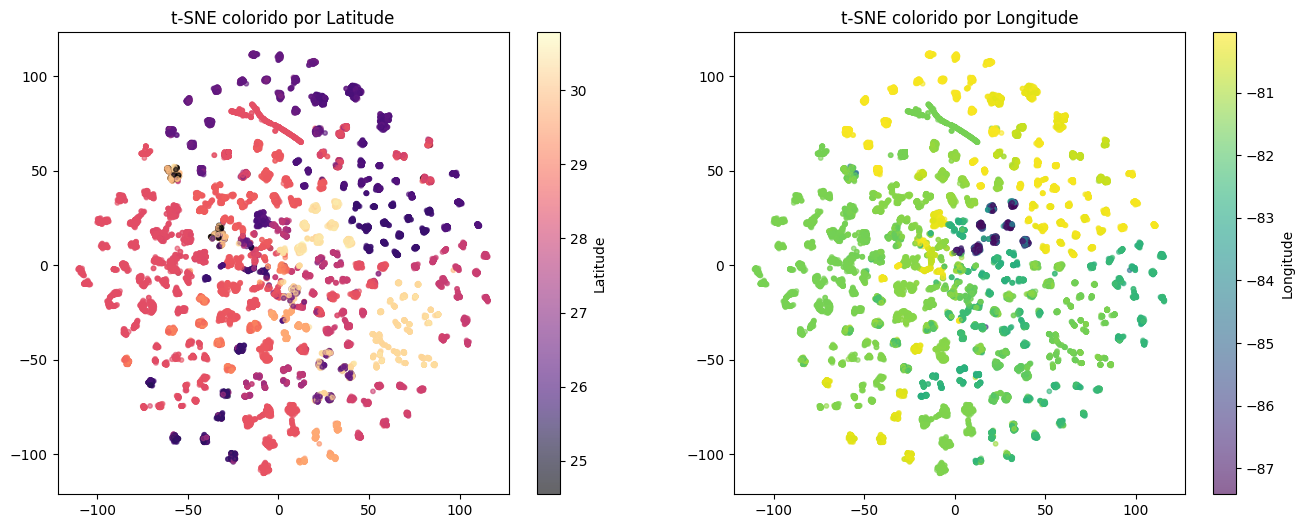

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

n_samples = 15000
indices = np.random.choice(len(loc_embeds), n_samples, replace=False)

subset_embeds = loc_embeds[indices]
subset_coords = coords[indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeds_2d = tsne.fit_transform(subset_embeds)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sc1 = ax[0].scatter(embeds_2d[:, 0], embeds_2d[:, 1],
                    c=subset_coords[:, 0], cmap='magma', s=10, alpha=0.6)
ax[0].set_title("t-SNE colorido por Latitude")
plt.colorbar(sc1, ax=ax[0], label='Latitude')

sc2 = ax[1].scatter(embeds_2d[:, 0], embeds_2d[:, 1],
                    c=subset_coords[:, 1], cmap='viridis', s=10, alpha=0.6)
ax[1].set_title("t-SNE colorido por Longitude")
plt.colorbar(sc2, ax=ax[1], label='Longitude')

plt.show()